In [1]:
!CUDA_VISIBLE_DEVICE=0

In [2]:
### CHANGE ACCORDING TO YOUR FILE SYSTEM ###
path_to_anndata = '/workspace/projects/001_scDiffusion/data/hannah_gb_dataset.h5ad'
path_to_saved_VAE_model = '/workspace/projects/001_scDiffusion/results/glioblastoma_Hannah/VAE_model/model_seed=0_step=39999.pt'
path_to_unconditional_sample = '/workspace/projects/001_scDiffusion/results/glioblastoma_Hannah/unconditional_latent_space/unconditional_GB.npz'

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
import sys
sys.path.append('/workspace/projects/001_scDiffusion/scripts/scDiffusion/') ### CHANGE TO THE PATH WHERE THE FOLDER VAE IS LOCATED
from VAE.VAE_model import VAE 

In [4]:
def load_VAE():
    autoencoder = VAE(
        num_genes=2579,
        device='cpu',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load(path_to_saved_VAE_model, map_location=torch.device('cpu')))
    return autoencoder

In [9]:
# LOAD REAL DATA
adata = sc.read_h5ad(path_to_anndata)[::80]
gene_names = adata.var_names
celltype = adata.obs['Level 3']
real_data = adata.X.toarray()
real_data.shape

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(2501, 2579)

In [10]:
# LOAD GENERATED DATA
npzfile=np.load(path_to_unconditional_sample,allow_pickle=True)
cell_gen_all = npzfile['cell_gen'][::]
autoencoder = load_VAE()
gen_data = autoencoder(torch.tensor(cell_gen_all),return_decoded=True).cpu().detach().numpy()
gen_data.shape

(3000, 2579)

In [13]:
# CONCATENATE, FILTER AND COMPUTE UMAP
adata = np.concatenate((real_data, gen_data),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs['cell_name'] = [f"real" for i in range(real_data.shape[0])]+[f"generated" for i in range(gen_data.shape[0])]
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


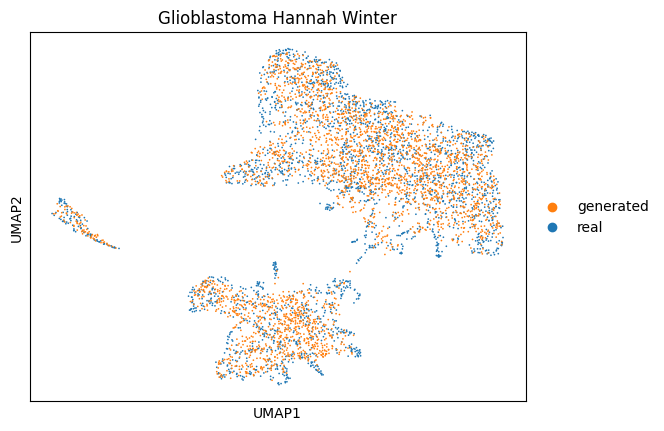

In [14]:
# PLOT THE UMAP
sc.pl.umap(adata=adata,color="cell_name",size=6,title='Glioblastoma Hannah Winter',palette={"real":"tab:blue", "generated":"tab:orange"})